In [2]:
import igraph
import copy
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import os
import glob
from helpers import *

%matplotlib inline

#why need download?
#3m resolution

#1. copublish use Ox' license 
#2. slider
#recurring problem - needs to look at construction sites
#
# Green info - little engine for 
# can we find another source?
# 

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
""" get all files """
files = glob.glob('./matrix_csvs/*')

g_MW_files = sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='green')and (f.split('/')[-1].split('_')[2]=='MW.csv') ) ])
b_MW_files =sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='blue') and (f.split('/')[-1].split('_')[2]=='MW.csv') )])
all_MW_files = sorted([f for f in files if ((f.split('/')[-1].split('_')[1]=='all') and (f.split('/')[-1].split('_')[2]=='MW.csv'))])

print all_MW_files

['./matrix_csvs/2004.75_all_MW.csv', './matrix_csvs/2007.75_all_MW.csv', './matrix_csvs/2008.75_all_MW.csv', './matrix_csvs/2009.75_all_MW.csv', './matrix_csvs/2010.75_all_MW.csv', './matrix_csvs/2011.5_all_MW.csv', './matrix_csvs/2012.75_all_MW.csv', './matrix_csvs/2013.75_all_MW.csv', './matrix_csvs/2014.75_all_MW.csv', './matrix_csvs/2015.0_all_MW.csv', './matrix_csvs/2015.25_all_MW.csv', './matrix_csvs/2015.5_all_MW.csv', './matrix_csvs/2015.75_all_MW.csv', './matrix_csvs/2016.0_all_MW.csv', './matrix_csvs/2016.25_all_MW.csv', './matrix_csvs/2016.5_all_MW.csv', './matrix_csvs/2016.75_all_MW.csv', './matrix_csvs/2017.0_all_MW.csv', './matrix_csvs/2017.25_all_MW.csv', './matrix_csvs/2017.5_all_MW.csv', './matrix_csvs/2017.75_all_MW.csv']


In [7]:
""" get a dict going with files and data """
data = {}
years = range(2007,2018)
years_m = [2007,2008,2009,2010,2012,2013,2014,2015,2016,2017]
for y in years_m:
    fname_all = [f for f in all_MW_files if ((str(y)+'.75') in f)][0]
    fname_g = [f for f in g_MW_files if ((str(y)+'.75') in f)][0]
    fname_b = [f for f in b_MW_files if ((str(y)+'.75') in f)][0]
    data[y]={'year':y,
             'fname_all':fname_all,
             'data_all':0.0,
             'fname_g':fname_g,
             'data_g':0.0,
             'fname_b':fname_b,
             'data_b':0.0}
    
data[2011]={'data_b': 0.0,
            'data_g': 0.0,
            'year': 2011,
            'fname_g': './matrix_csvs/2011.5_green_MW.csv',
            'fname_b': './matrix_csvs/2011.5_blue_MW.csv',
            'data_all': 0.0,
            'fname_all': './matrix_csvs/2011.5_all_MW.csv'}
    
print data[2016]['data_all']
print data

0.0
{2016: {'data_b': 0.0, 'data_g': 0.0, 'year': 2016, 'fname_g': './matrix_csvs/2016.75_green_MW.csv', 'fname_b': './matrix_csvs/2016.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2016.75_all_MW.csv'}, 2017: {'data_b': 0.0, 'data_g': 0.0, 'year': 2017, 'fname_g': './matrix_csvs/2017.75_green_MW.csv', 'fname_b': './matrix_csvs/2017.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2017.75_all_MW.csv'}, 2007: {'data_b': 0.0, 'data_g': 0.0, 'year': 2007, 'fname_g': './matrix_csvs/2007.75_green_MW.csv', 'fname_b': './matrix_csvs/2007.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2007.75_all_MW.csv'}, 2008: {'data_b': 0.0, 'data_g': 0.0, 'year': 2008, 'fname_g': './matrix_csvs/2008.75_green_MW.csv', 'fname_b': './matrix_csvs/2008.75_blue_MW.csv', 'data_all': 0.0, 'fname_all': './matrix_csvs/2008.75_all_MW.csv'}, 2009: {'data_b': 0.0, 'data_g': 0.0, 'year': 2009, 'fname_g': './matrix_csvs/2009.75_green_MW.csv', 'fname_b': './matrix_csvs/2009.75_b

In [8]:
""" read in all the data """
for y in years:
    print y
    data[y]['data_all']=pd.read_csv(data[y]['fname_all'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_g']=pd.read_csv(data[y]['fname_g'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_b']=pd.read_csv(data[y]['fname_b'], encoding='utf-8').set_index('COMPANY')
    data[y]['data_ff'] = data[y]['data_all'].subtract(data[y]['data_g'], fill_value=0.0).subtract(data[y]['data_b'], fill_value=0.0)

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [9]:
""" read in the countries """
country_df = pd.read_csv('country_iso_regions.csv', encoding='utf-8').set_index('country')

In [10]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def degree(x):
    #print x
    #print 'softmax: ', softmax(x)
    #raw_input('-->')
    return np.sum(softmax(x)/np.max(x))/x.shape[0]

In [11]:
#print data[2016]['data_ff']
regions = country_df.SIPS_REGION.unique()
print list(country_df)
print country_df.SIPS_REGION.unique()

sample_ff = data[2016]['data_ff'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_g = data[2016]['data_g'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_b = data[2016]['data_b'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
sample_all = data[2016]['data_all'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T



print sample_ff.shape
print sample_g[sample_all['AFRICA']>0][['AFRICA']]/sample_all[sample_all['AFRICA']>0][['AFRICA']]
#print sample_b.shape
#print sample_all.shape
#print sample_all[sample_all['AFRICA']>0].shape
#print sample_g[sample_all['AFRICA']>0].shape
#print sample_g.T.sum()/sample_all.T.sum()

print clamp(16)

['Unnamed: 0', u'iso2', u'iso3', u'iso_num', u'region', u'region_IEA', u'region_IEA_secondary', u'region_IEA_final', u'SIPS_REGION', u'urban_pop', u'rural_pop', u'population', u'portion']
[u'OTHERX' u'TE' u'AFRICA' u'LAM' u'OECD_PAC' u'OECD_EUR' u'ME' u'OECD_AMX'
 u'CN' u'IN' u'US']
(34618, 11)
SIPS_REGION                       AFRICA
ESKOM                           0.002407
SOC ALGERIENNE ELEC (SONELGAZ)  0.000000
GENERAL ELECTRICITY CO LIBYA    0.124224
CAIRO ELEC PROD CO (CEPC)       0.164175
EAST DELTA ELECTRICITY PROD CO  0.100205
MIDDLE DELTA ELEC PROD CO       0.306921
WEST DELTA ELEC PRODUCTION CO   0.061237
OFF NATL L'ELEC L'EAU (ONEE)    0.076054
SOC TUNISIENNE ELEC GAZ (STEG)  0.073992
ETHIOPIAN ELECTRIC POWER CORP   0.031370
UPPER EGYPT ELEC PRODUCTION CO  0.124564
ACWA POWER DEVELOPMENT          1.000000
HYDRO PLANTS ELEC PROD CO       0.000000
GLOBAL POWER GENERATION         0.000000
EDF ENERGIES NOUVELLES          0.905213
NIGER DELTA POWER HOLDING CO    0.000000
SOC ALG

In [12]:
def str_col(g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(int(g)), clamp(int(b)))

OTHERX
2007
3.22582599146
2008
3.24501887074
2009
3.26764098235
2010
3.29269900304
2011
3.3049211619
2012
3.3467440546
2013
3.3602146133
2014
3.38165648259
2015
3.40483371662
2016
3.41962536089
2017
3.43200668727


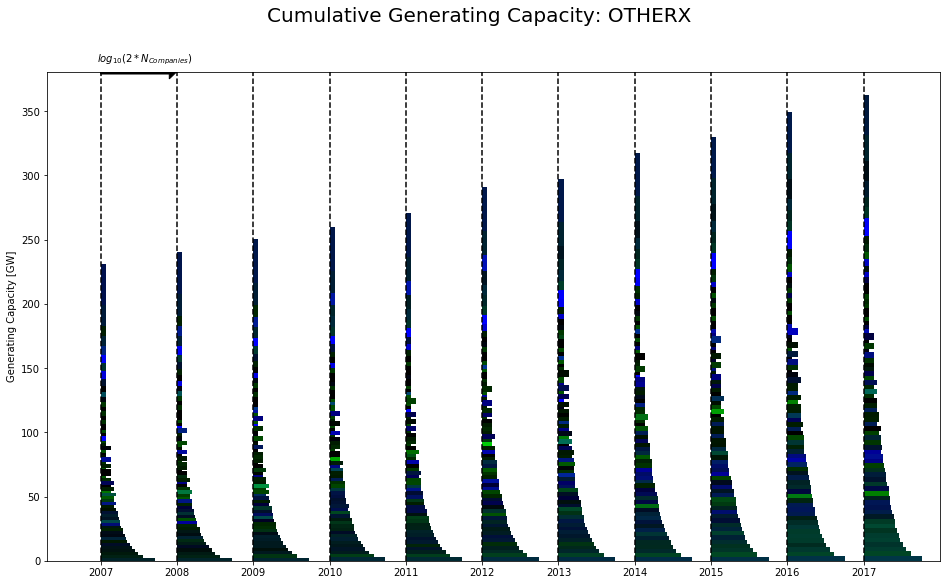

TE
2007
2.83632411571
2008
2.90741136077
2009
2.97127584874
2010
3.02530586526
2011
3.0476641946
2012
3.13924921757
2013
3.20139712432
2014
3.27646180417
2015
3.3242824553
2016
3.3384564936
2017
3.39234515536


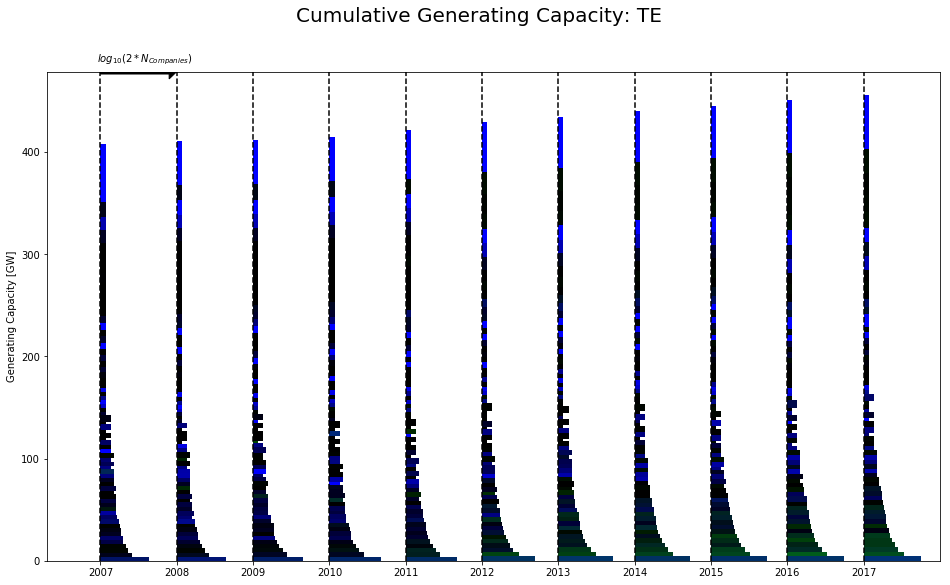

AFRICA
2007
2.82736927305
2008
2.87390159786
2009
2.90848501888
2010
2.92634244663
2011
2.94051648493
2012
2.97034687623
2013
2.99299509843
2014
3.01367969729
2015
3.03742649794
2016
3.06145247909
2017
3.08493357494


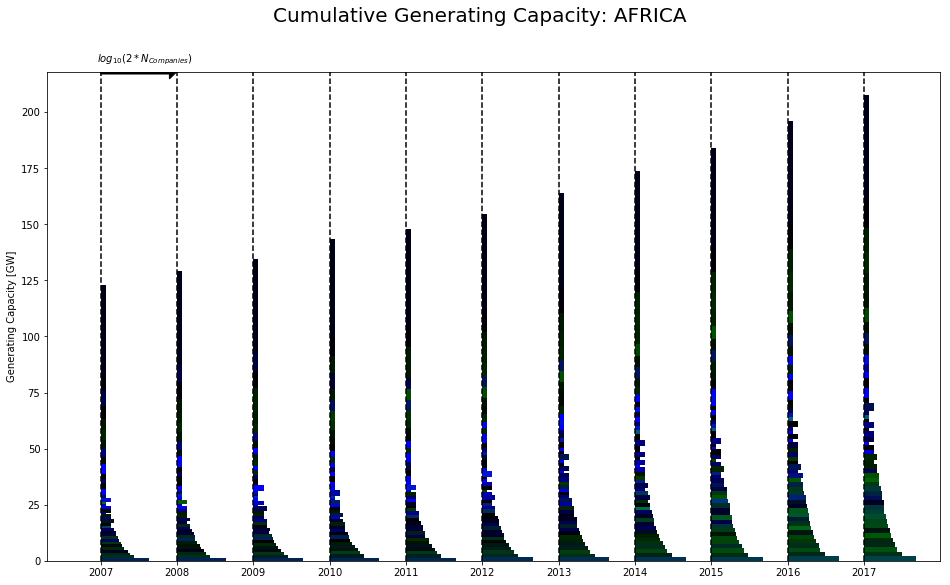

LAM
2007
3.0170333393
2008
3.03342375549
2009
3.05307844348
2010
3.06595298031
2011
3.07700432679
2012
3.16256440652
2013
3.17897694729
2014
3.19423674872
2015
3.2284003587
2016
3.24600590408
2017
3.2552725051


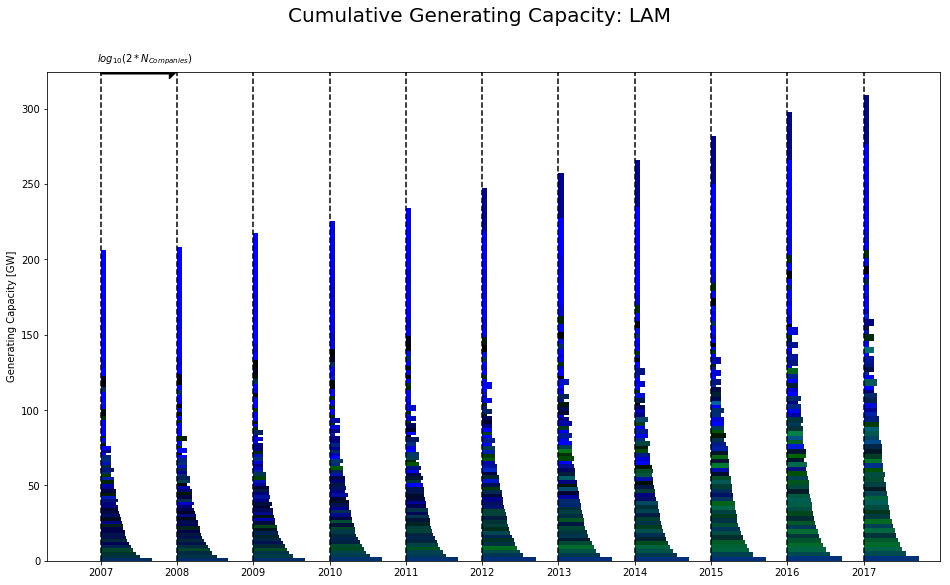

OECD_PAC
2007
3.5615783683
2008
3.56796690682
2009
3.57472558359
2010
3.5829719291
2011
3.58681226944
2012
3.59417147911
2013
3.60379370414
2014
3.61257195407
2015
3.61971926561
2016
3.63063124402
2017
3.63968566124


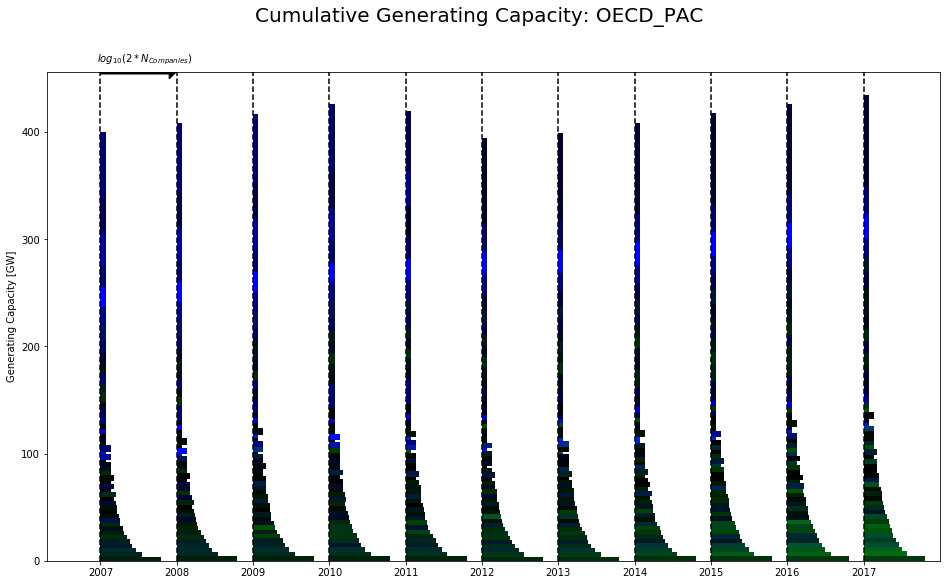

OECD_EUR
2007
4.12004719435
2008
4.14538289197
2009
4.16172726972
2010
4.18150058847
2011
4.19234439505
2012
4.21181443046
2013
4.24014971331
2014
4.26207121262
2015
4.27701293938
2016
4.2874882084
2017
4.2985911113


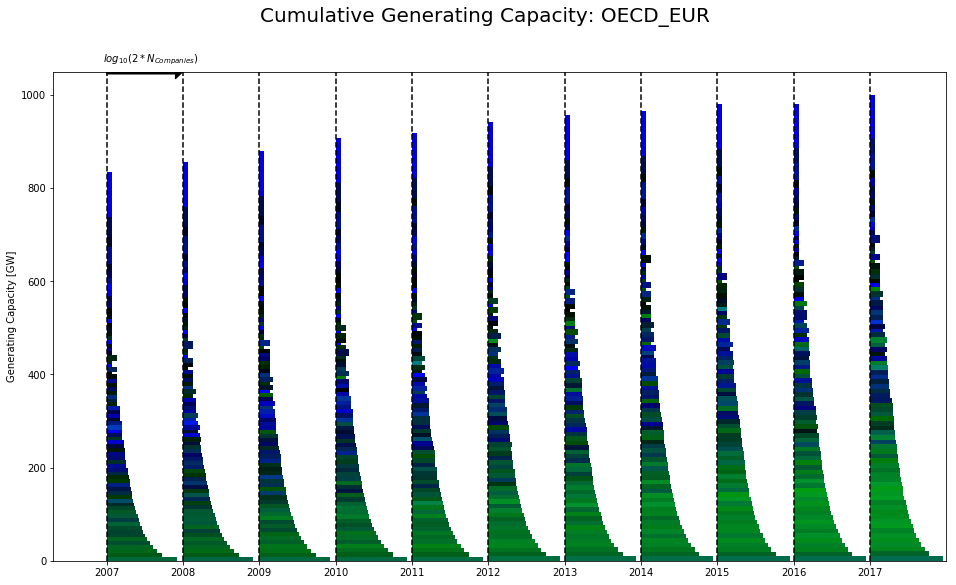

ME
2007
2.48287358361
2008
2.49692964807
2009
2.49968708262
2010
2.52374646681
2011
2.54654266348
2012
2.57518784493
2013
2.58658730467
2014
2.60422605308
2015
2.62736585659
2016
2.64345267649
2017
2.68484536164


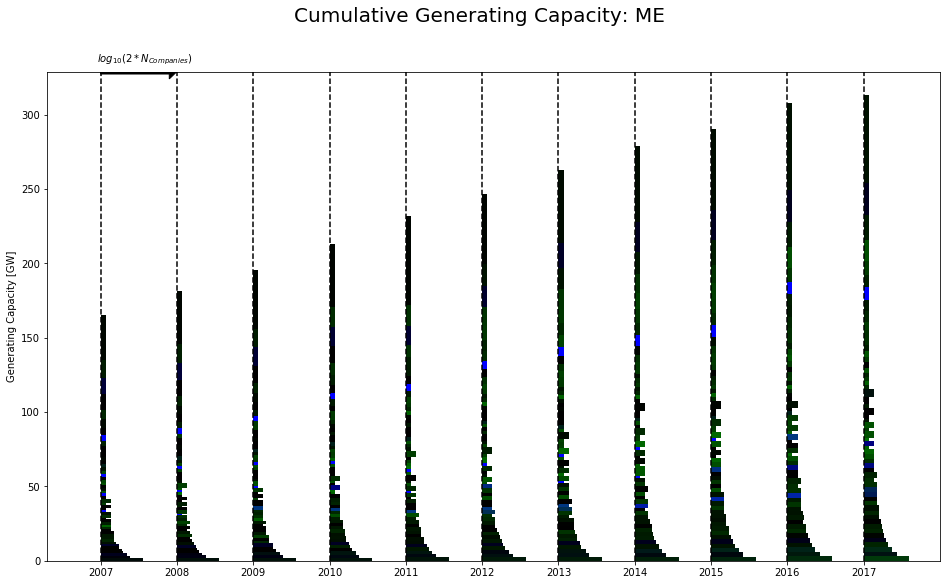

OECD_AMX
2007
2.78390357927
2008
2.79518458968
2009
2.81822589361
2010
2.84880470105
2011
2.86332286012
2012
2.91381385238
2013
2.94743372189
2014
3.007747778
2015
3.09691001301
2016
3.17955179117
2017
3.19368102954


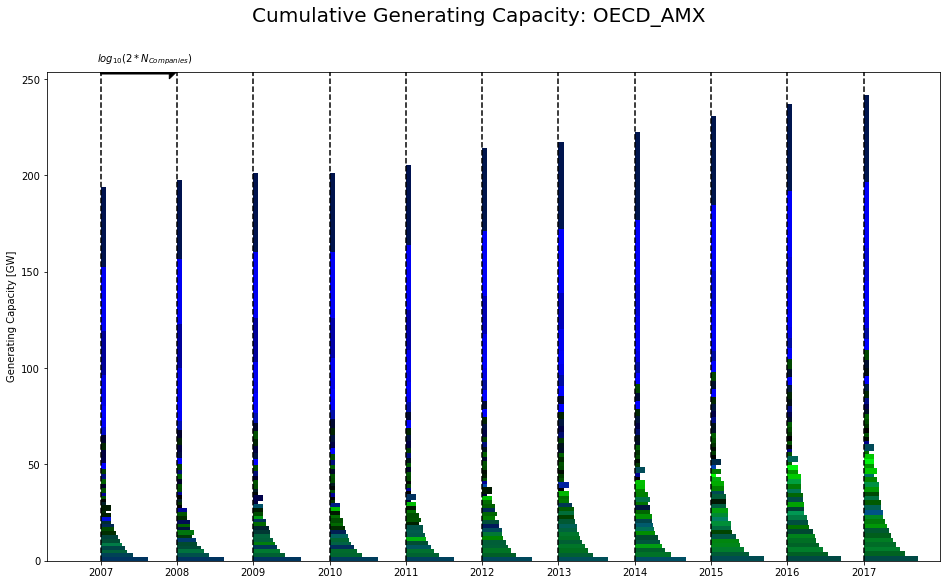

CN
2007
2.7371926427
2008
2.80753502807
2009
2.8785217955
2010
2.92220627744
2011
2.97127584874
2012
3.01619735351
2013
3.08707120591
2014
3.13353890837
2015
3.1535099893
2016
3.16731733475
2017
3.17782497186


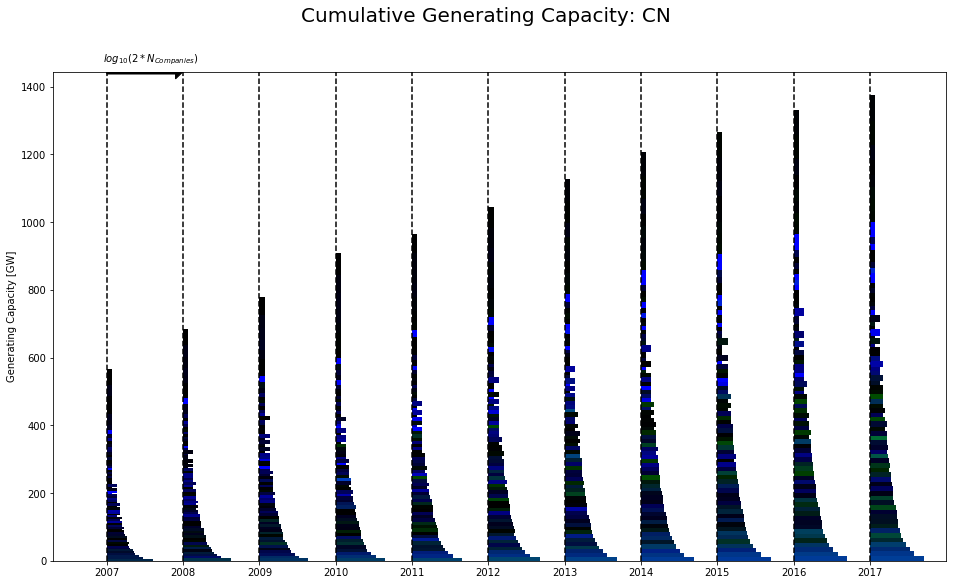

IN
2007
2.98317507204
2008
3.02036128265
2009
3.03582982525
2010
3.07114529045
2011
3.08919836681
2012
3.13353890837
2013
3.16316137498
2014
3.188647296
2015
3.21431389742
2016
3.23248786635
2017
3.26387267687


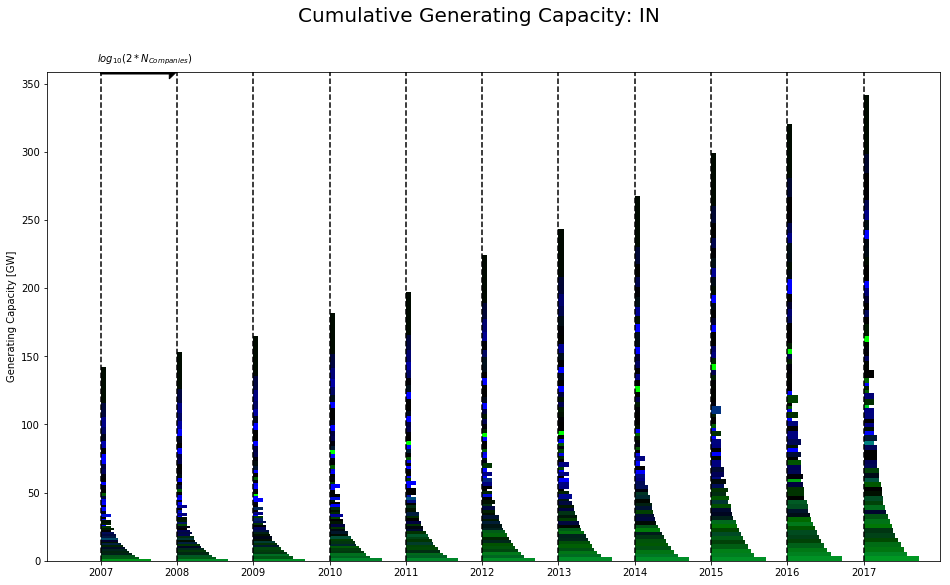

US
2007
3.80807586809
2008
3.81888541459
2009
3.84335737844
2010
3.86308482532
2011
3.87262237903
2012
3.89773702535
2013
3.91019736997
2014
3.91834492896
2015
3.92767826414
2016
3.93711651077
2017
3.94240494086


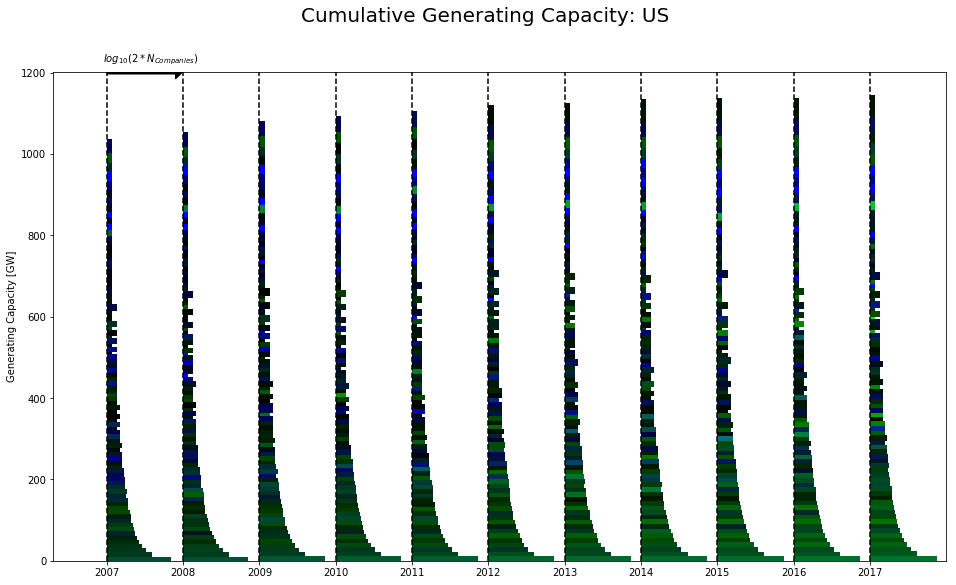

In [30]:
""" let's plot em all """
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


for r in regions:
    print r
    f, axarr = plt.subplots(1, figsize=(16,9))
    axarr.set_xlim(2006.3,2018)
    axarr.set_xticks(years)
    
    for y in years:
        
        print y
        
        sample_ff = data[y]['data_ff'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_g = data[y]['data_g'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_b = data[y]['data_b'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T
        sample_all = data[y]['data_all'].T.merge(country_df[['SIPS_REGION','iso2']], left_index=True, right_on='iso2').groupby('SIPS_REGION').sum().T

        #"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b))
        pos = sample_all[sample_all[r]>0][[r]]
        #g = sample_g[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        #b = sample_b[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        
        pos = pos.sort_values(r, ascending=True)/1000.0
        pos['cumsum'] = pos[r].cumsum()
        pos['bin']=(pos['cumsum']/pos['cumsum'].max()*100).astype(int)

        
        #pos = pos.sort_values('cumsum', ascending=False)

        pos['g'] = sample_g[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        pos['b'] = sample_b[sample_all[r]>0][[r]]/sample_all[sample_all[r]>0][[r]]*255.0
        pos['color'] = pos.apply(lambda row: str_col(row['g'], row['b']), axis=1)
        #print pos
        
        down_sample = pos.groupby('bin').sum()
        down_sample['count'] = pos[['bin',r]].groupby('bin').count()
        down_sample.g = down_sample.g/down_sample['count']
        down_sample.b = down_sample.b/down_sample['count']
        down_sample['cumsum']=down_sample[r].cumsum()
        down_sample['color']=down_sample.apply(lambda row: str_col(row['g'], row['b']), axis=1)
        down_sample['log10count'] = np.log10(down_sample['count'])+np.log10(2.0)
        #print down_sample
        
        
        axarr.axvline(x=y, color='k', linestyle='--')
        """
        axarr.barh(pos['cumsum'].values-pos[r].values, #position
                   (1.0-pos['cumsum'].values/(pos['cumsum'].max())*0.9), #width
                   pos[r].values, #height
                   y,
                   align='edge',
                   color=pos.color.values)
        """
        print down_sample['log10count'].max()
        axarr.barh(down_sample['cumsum'].values-down_sample[r].values, #position
                   down_sample['log10count']/4.5, #down_sample['log10count'].max(),#(1.0-down_sample['cumsum'].values/(down_sample['cumsum'].max())*0.9), #width
                   down_sample[r].values, #height
                   y,
                   align='edge',
                   color=down_sample.color.values)
        
        
        #ariel deranger
        #raw_input('-->')
    #print pos
    axarr.set_ylabel('Generating Capacity [GW]')
    axarr.set_ylim(bottom=0.0)
    
    bottom,top = axarr.get_ylim()
    
    axarr.arrow(2007, top, .9, 0, head_width=(top-bottom)*0.03, head_length=0.1, fc='k', ec='k', width=(top-bottom)*0.01)

    axarr.text(2006.95, top+(top-bottom)*0.02,'$log_{10}(2*N_{Companies}$)')
    
    green_patch = mpatches.Patch(color='green', label='green data')
    blue_patch = mpatches.Patch(color='blue', label='blue data')
    black_patch = mpatches.Patch(color='black', label='black data')
    
    f.legend((black_patch,blue_patch,green_patch), ('Fossil Fuels','Nuclear & Large-Scale Hydro','Renewables'), loc='center', bbox_to_anchor=(0.5,0.92), ncol=3)

    f.suptitle('Cumulative Generating Capacity: '+str(r), fontsize=20)
    f.savefig('./figures/1_'+str(r)+'.png')
    plt.show()
        

In [ ]:
""" get dregree for all data"""

for y in years:
    for data_str in ['data_all','data_g','data_b', 'data_ff']:
        df = data[y][data_str]
        #degree just with connections
        df['degree'] = df[df>0].count(axis=1)
    
        #degree with algo
        #df['degree'] = df.apply(lambda row: degree(row/np.sum(row)), axis=1)
    

        cols = [c for c in list(df) if len(c)<3]
        df['sum'] = df[cols].sum(axis=1)
        df['cumsum'] = df['sum'].cumsum()
    
        data[y][data_str] = df.sort_values('sum', ascending=False)


In [ ]:
""" lets plot them degrees """
import matplotlib.patches as mpatches
import matplotlib.lines as mlines



f, axarr = plt.subplots(3,sharex=True, figsize=(16,9))
axarr[0].set_xlim(2006.3,2018)
axarr[0].set_xticks(years)
#axarr[0].set_xtickabels(years)

axarr[0].set_ylim(0,100)
axarr[1].set_ylim(0,100)
axarr[2].set_ylim(0,100)

axarr[0].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)
axarr[1].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)
axarr[2].arrow(2008, 100.0, .9, 0, head_width=5, head_length=0.1, fc='k', ec='k', width=2)

axarr[0].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[1].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[2].arrow(2006.8, 50.0, 0, -40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)

axarr[0].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[1].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)
axarr[2].arrow(2006.8, 50.0, 0, 40, head_width=.1, head_length=10, fc='k', ec='k', width=.01)

axarr[0].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)
axarr[1].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)
axarr[2].text(2006.7, 80,'small\ncompanies', ha='right', rotation=90)

axarr[0].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)
axarr[1].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)
axarr[2].text(2006.4, 30,'large\ncompanies', ha='left', rotation=90)

axarr[0].text(2007.95, 105,'d=1')
axarr[1].text(2007.95, 105,'d=1')
axarr[2].text(2007.95, 105,'d=1')

axarr[0].text(2008.95, 105,'d=5')
axarr[1].text(2008.95, 105,'d=5')
axarr[2].text(2008.95, 105,'d=5')

cols_dict={0:'black',1:'blue',2:'green'}

axarr[0].set_ylabel('%$N_{Companies, Fossil Fuel}$')
axarr[1].set_ylabel('%$N_{Companies, Nuclear & Hydro}$')
axarr[2].set_ylabel('%$N_{Companies, Renewables}$')

degree_means = []

for y in years:
    print y
    ii=0
    for data_str in ['data_ff','data_b','data_g']:
        df = data[y][data_str]
        degree_means.append(df.degree.mean())
    
        df = df.drop(df[df.degree<1.0].index)
        #print df['sum'].sum(axis=0)
        verts = np.arange(len(df))/float(len(df))*100
        degrees = ((df.degree.rolling(50, min_periods=1).mean())-1.0)/4.0#-df.degree.min())*500
        #print 'max degrees', degrees.max()*5
        #print degrees
        degrees_std = degrees+(df.degree.rolling(50, min_periods=1).std())/4.0#*500
        #print 'max std', degrees_std.max()*5
        degrees = degrees+y
        degrees_std = degrees_std+y
        #print degrees.values
    
        #print verts
        #print degrees
        #print degrees_std
        axarr[ii].plot(degrees.values,verts, color=cols_dict[ii])
        axarr[ii].fill_betweenx(verts,y,degrees_std.values, alpha=0.3, color=cols_dict[ii])
        #axarr[0].plot(degrees_std.values,verts)
        #vert = np.arange(len(df))/df['sum'].sum(axis)
    

        axarr[ii].axvline(x=y, color='k', linestyle='--')
    
        #print data[y]['data']
    
        #axarr[2].scatter(df_test['degree'],df_test['cumsum'])
        #axarr[2].violinplot(df_test['degree'],positions = [1.0], widths=50, points=10000)
        #axarr[2].set_ylabel('ALL_Cumulative_Sum')
        #f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
        
        ii+=1
f.suptitle('Degree Distributions for all Companies', fontsize=20)


gray_patch = mpatches.Patch(color='gray', label='The red data')
black_line = mlines.Line2D([0],[0],color='black')

f.legend((black_line,gray_patch), ('$Rolling\_Mean_{window=50}$','$Rolling\_StdDev_{window=50}$'), loc='center', bbox_to_anchor=(0.5,0.92), ncol=2)
f.savefig('out.png')
plt.show()

print np.mean(degree_means)


In [ ]:
print data[2017]['data_all'].degree.rolling(50, min_periods=1).std().argmax()

print data[2017]['data_all'].degree.rolling(50, min_periods=1).std().to_string()

In [ ]:
print data[2017]['data_all']# - data[2017]['data_g'] - data[2017]['data_b']

In [ ]:
"""Let's do this a fan graph"""


df_all = pd.read_csv(all_MW_files[0], encoding='utf-8').set_index('COMPANY')
df_g = pd.read_csv(g_MW_files[0], encoding='utf-8').set_index('COMPANY')

df_test = pd.DataFrame(df_all.sum(axis=1).sort_values(ascending=False), columns=['sum'])
df_test['cumsum'] = df_test['sum'].cumsum()
#df_test['degree'] = df_all[df_all>0.0001].count(axis=1)
df_test['degree'] = df_all.apply(lambda row: degree(row/np.sum(row)), axis=1)

print df_test.sort_values('sum',ascending=False)
#df_test.plot('cumsum','degree')

#https://stackoverflow.com/questions/28807169/making-a-python-fan-chart-fan-plot
#https://matplotlib.org/examples/pylab_examples/boxplot_demo.html

f, axarr = plt.subplots(3, sharex=True, figsize = (16,9))
axarr[2].scatter(df_test['degree'],df_test['cumsum'])
#axarr[2].violinplot(df_test['degree'],positions = [1.0], widths=50, points=10000)
axarr[2].set_ylabel('ALL_Cumulative_Sum')
#f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
plt.show()
plt.close()
plt.clf()

#print df_all.T.sum().cumsum()
#print df_g.T.sum()
#

print df_test.shape[1]
test = np.zeros((215))
test[5]=1
test[15]=1
test[24]=1
test[30]=1
print test
print 'test degree: ',degree(test.T/np.sum(test.T))


"algo degree"
#print df_all.apply(lambda row: degree(row/np.sum(row)), axis=1).plot()
#print df_g[df_g>0.0001].count(axis=1).plot()
#print df_all[df_all>0.0001].count(axis=1).plot()
#print df_all.apply() / df_all.T.max()

In [ ]:
print df_test
print df_test.degree.rolling(1000, min_periods=1).mean().plot()
print df_test.degree*100
print df_test.degree.rolling(1000, min_periods=1).std().plot()
#print len(df_test.degree.rolling(100, min_periods=1).mean().resample('1'))

In [ ]:
print (full_d_range.days)
	x_ticks = np.arange(0,full_d_range.days,365)
	print (x_ticks.shape)
	x_tick_labels = [str(i) for i in range(2008,2019)]
	print (len(x_tick_labels))
	f, axarr = plt.subplots(3, sharex=True, figsize = (16,9))
	axarr[0].scatter(x, y_area, marker='+')
	axarr[0].set_ylabel('Area [m^2]')
	axarr[0].set_xlim(0,full_d_range.days)
	axarr[0].set_xticks(x_ticks)
	axarr[0].set_xticklabels(x_tick_labels)
	axarr[0].set_title('Extents indicators for '+path['ID']+': '+path['name'])
	axarr[1].scatter(x, y_exts, marker='+')
	axarr[1].set_ylabel('Fraction')
	axarr[1].set_ylim(bottom=0.0)
	#print(y_vals)
	for y in y_vals:
		print (y.shape)
	axarr[2].violinplot(y_vals,positions = x, widths=50, points=1000)
	axarr[2].set_ylabel('values')
	f.savefig(os.path.join('output',path['ID'],'_ndwi_stats.png'))
	#plt.show()
	#plt.close()
	plt.clf()

In [ ]:
path_to_matrices = "matrix_csvs/"
years = ["2004"] + ["2007"] + [str(i) for i in range(2014,2018)] #list of all years
quarters = [".0", ".25", ".5", ".75"] #list of all quarters

In [ ]:
#Stating period for analisis
y_index = -2
q_index = 3
current_year = years[y_index] + quarters[q_index] #The year and quarter we will do the analisis for

#Importing the files needed
df_all = pd.read_csv(path_to_matrices + current_year + "_all_projection.csv")
names = list(df_all.columns[1:]) #Getting names of nodes
n_countries = len(names)
ADJ_all = np.loadtxt(open(path_to_matrices + current_year + "_all_projection.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
#files are empty
#pd.read_csv(path_to_matrices + current_year + "_blue_projection.csv")
#Adjmat_blue = np.loadtxt(open(path_to_matrices + current_year + "_blue_projection.csv", "rb"), delimiter=",", skiprows=1, 
           #usecols=range(1,n_countries+1)) #getting the adjacency matrix
#Adjmat_green = np.loadtxt(open(path_to_matrices + current_year + "_green_projection.csv", "rb"), delimiter=",", skiprows=1, 
           #usecols=range(1,n_countries+1)) #getting the adjacency matrix

Note, in year 2004 there is hardly little influence between countries. In year 2017 there is more, although still not a lot (think?)

In [ ]:
print(np.diagonal(ADJ_all)) #Is this correct? A "1" in the diagonal would indicate the country is not influenced
#by any other country?
plt.imshow(ADJ_all) #Few influence between countries?
plt.colorbar()

In [ ]:
#This is an isolated node.
ADJ_all[0]

In [ ]:
#Only small countries can be influenced?
print("Small diagonal value")
for i in range(n_countries):
    if np.diagonal(ADJ_all)[i] < 0.5:
        print i, " ", names[i]

In [ ]:
#PageRank centrality with igraph
G_all =  igraph.Graph.Weighted_Adjacency(ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"], directed=True)
names_copy = copy.copy(names)
inds = np.array(pr_all).argsort()[::-1][:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]
sort_names_pr, sort_centrality_pr
plt.plot(pr_all, "o")

### Loading matrices and making projections

In [ ]:
#Extracting bipartite adj mat
ADJ_bip_green = np.loadtxt(open(path_to_matrices + current_year + "_green_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
ADJ_bip_blue = np.loadtxt(open(path_to_matrices + current_year + "_blue_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) #getting the adjacency matrix
#Does the all category include the green and blue or is it just the dirty ones? In principle we would like to have 
#only the dirty ones, right?
ADJ_bip_all = np.loadtxt(open(path_to_matrices + current_year + "_all_MW.csv", "rb"), delimiter=",", skiprows=1, 
           usecols=range(1,n_countries+1)) 
#To get the high emission plants we use the all matrix and remove the "clean" part
ADJ_bip_dirty = ADJ_bip_all - (ADJ_bip_green + ADJ_bip_blue)


#Making the company projection
ADJ_comp_green =  (ADJ_bip_green/ADJ_bip_green.sum()).dot(ADJ_bip_green.T/(ADJ_bip_green.T.sum()))
ADJ_comp_blue =  (ADJ_bip_blue/ADJ_bip_blue.sum()).dot(ADJ_bip_blue.T/(ADJ_bip_blue.T.sum()))
ADJ_comp_all =  (ADJ_bip_all/ADJ_bip_all.sum()).dot(ADJ_bip_all.T/(ADJ_bip_all.T.sum()))
ADJ_comp_dirty =  (ADJ_bip_dirty /ADJ_bip_dirty .sum()).dot(ADJ_bip_dirty.T/(ADJ_bip_dirty .T.sum()))
#Making the country projection
ADJ_country_green =  (ADJ_bip_green.T/ADJ_bip_green.T.sum()).dot(ADJ_bip_green/(ADJ_bip_green.sum()))
ADJ_country_blue =  (ADJ_bip_blue.T/ADJ_bip_blue.T.sum()).dot(ADJ_bip_blue/(ADJ_bip_blue.sum()))
ADJ_country_all =  (ADJ_bip_all.T/ADJ_bip_all.T.sum()).dot(ADJ_bip_all/(ADJ_bip_all.sum()))
ADJ_country_dirty =  (ADJ_bip_dirty.T /ADJ_bip_dirty.T .sum()).dot(ADJ_bip_dirty/(ADJ_bip_dirty.sum()))

#Getting the percentage of emissions of each type for each country
green_part = [sum(ADJ_bip_green[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]
blue_part = [sum(ADJ_bip_blue[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]
dirty_part = [sum(ADJ_bip_dirty[:, i])/sum(ADJ_bip_all[:, i]) for i in range(n_countries)]

# Multilayer analysis

In [ ]:

def make_supra_adj(ADJ_list, COUP_list):
    """Function that takes list of adj matrix and coupling and generates the supra adjacency matrix of the
    multiplex network
    Args:
        ADJ_list: list of numpy 2D array's. Each of them is an adjacency matrix
        COUP_list: list of numpy 1D array's. Each of them is the vector to be used for coupling the matrices
    Return:
        Supra Adjacency matrix. Numpy 2D array.
    """
    n_layers = len(ADJ_list)
    n_nodes = ADJ_list[0].shape[0]
    
    #stacking up adjacency matrix and coupling accordingly
    sup_list = []
    for i in range(n_layers):
        row = []
        for j in range(n_layers):
            if i == j: #if in diagonal add adjacency matrix
                row.append(ADJ_list[i])
                #print(ADJ_list[i].shape)
            else: #otherwise add the coupling (diagonal since multiplex network)
                row.append(np.diag(COUP_list[i])) #if i or j here defined direction of coupling
                #print(np.diag(COUP_list[i]).shape)
        sup_list.append(row)
        
    return np.bmat(sup_list)
    
n_nodes = n_countries
n_layers = 3
#The following function is taylored for igraph centrality
def flatten_centrality(centrality_vector, n=n_nodes, l=n_layers, names=names, hubauth=False):
    '''Centrality networks in a Multiplex are commonly expressed as a vector of
    nlx1 dimension. To have a centrality for each node it is important to flatten
    the vector into nx1 dimension. Also, it is important return a list of ranked
    nodes and another of their score.
    Args
    centrality_vector(numpy array): the centrality measure for each node-layer
    n(int): number of nodes
    l(int): number of layers
    names(list of strings): name of nodes (countries)
    hubauth(boolean): indicating if the centrality is hub or authority
    Return:
    sort_names_multi(list of strings): names of countries ordered by centrality
    sort_centrality_multi(list of flots): sorted score of nodes
    '''
    multi_centrality = []
    for i in range(n):
        cent = 0
        for k in range(l):
            cent += centrality_vector[i + n*k]
        if hubauth:
            multi_centrality.append(cent[0])
        else:
            multi_centrality.append(cent)
    node_names = np.array(copy.deepcopy(names))
    inds = np.array(multi_centrality).argsort()[::-1][:]
    sort_names_multi = node_names[inds]
    sort_centrality_multi = np.array(multi_centrality)[inds]
    
    return sort_names_multi, sort_centrality_multi    


In [ ]:
#Making the supra adjacency matrix
SUPADJ_country = make_supra_adj([ADJ_country_green, ADJ_country_blue, ADJ_country_dirty], [green_part, blue_part, dirty_part]) 

In [ ]:
#making the graph
G_supra = igraph.Graph.Weighted_Adjacency( SUPADJ_country.tolist() ,mode="directed") 
#computing pagerank
pr_muliplex = G_supra.personalized_pagerank(weights=G_supra.es["weight"])
#sorting it appropriately
pr_multiplex_sorted = flatten_centrality(pr_muliplex)

In [ ]:
pr_multiplex_sorted

Comparing it with the aggregate pagerank centrality

In [ ]:
G_all =  igraph.Graph.Weighted_Adjacency( ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"])
names_copy = copy.copy(names)
inds = np.array(pr_all).argsort()[:]
#If small countries are first, try including the [::-1 as below]
#inds = np.array(pr_all).argsort()[::-1][:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]

In [ ]:
sort_names_pr, sort_centrality_pr

# Inconsistency between networkx and igraph?
I tend to trust igraph more, however the discrepancy might mean that values in general are too close. Perhaps networkx power method is not converging?

In [ ]:
#PageRank centrality with igraph
G_all =  igraph.Graph.Weighted_Adjacency(ADJ_all.tolist() ,mode="directed")
pr_all = G_all.personalized_pagerank(weights=G_all.es["weight"], directed=True)
names_copy = copy.copy(names)
#inds = np.array(pr_all).argsort()[::-1][:]
inds = np.array(pr_all).argsort()[:]
sort_names_pr = np.array(names_copy)[inds]
sort_centrality_pr = np.array(pr_all)[inds]
sort_names_pr, sort_centrality_pr

#PageRank centrality with networkx
G_all_nx = nx.from_numpy_matrix(ADJ_all)
pr_all_nx = nx.pagerank(G_all_nx, weight="weight")
plt.plot(pr_all_nx.values(), "o")
plt.plot(pr_all, ".")

In [ ]:
plt.plot(pr_all, pr_all_nx.values(), "o")

In [ ]:
for i in range(n_countries):
    print i, "nx = ", names[sorted(pr_all_nx.items(), key=lambda x:x[1])[::-1][i][0]], "ig = ", sort_names_pr[i]

In [ ]:
#If we want to do Hubs and Auth the following code will be usefull
"""def G_list_hub(G_adj_list):
    '''
    Args(list): list of graphs adjacency matrices
    Return(list): list of adjacency matrices to be used in the block diagonal
    of the supra adjacency matrix for hub score
    '''
    G_hub = []
    for g in G_adj_list:
        new = np.dot(g, g.transpose())
        G_hub.append(new)
    return G_hub

def G_list_auth(G_adj_list):
    '''
    Args(list): list of graphs adjacency matrices
    Return(list): list of adjacency matrices to be used in the block diagonal
    of the supra adjacency matrix for auth score
    '''
    G_auth = []
    for g in G_adj_list:
        new = np.dot( g.transpose(), g)
        G_auth.append(new)
    return G_auth

def hub_auth_diag(Coup_list):
    coup = []
    for c in Coup_list:
        coup.append(c*c)
    return coup"""


In [ ]:
pd.__version__
